<a href="https://colab.research.google.com/github/Aquib88raza/image-classification-ANKLE/blob/main/ankle_1%20new%20fianl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [76]:
# @title PROJECT LABEL

# Project:

# Tools: Python --version
#        Scikit-learn - deep learning python library

# README:

# Dataset:

# Usefull infos:
# https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0265949

In [77]:
# @title IMPORTS

import os
import random
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV, StratifiedKFold, cross_val_predict
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

In [78]:
# @title DEFINITIONS

classifiers_names = [
    "KNeighborsClassifier",
    "SVC",
    'MultinomialNB',
    "DecisionTreeClassifier",
    "RandomForestClassifier"
]

classifiers = [
    KNeighborsClassifier(),
    SVC(),
    MultinomialNB(),
    DecisionTreeClassifier(),
    RandomForestClassifier()
]

parameters = [
    {'n_neighbors': [3, 5, 7, 9, 11, 13]},  # KNeighborsClassifier
    {'C': [1, 10, 50, 70, 100]}, #'gamma':['scale', 'auto'], 'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 'class_weight': [None, 'balanced']}, # SVC
    {'alpha': [0.1, 0.5, 1.0]},  # MultinomialNB
    {'max_depth': [None, 3, 5, 7, 10]},  # DecisionTreeClassifier
    {'n_estimators': [50, 100, 200, 300, 500]}, #'warm_start': [True, False], 'n_jobs':[None, 1, 2, 3]}  # RandomForestClassifier
]

healthy_datset = []
ill_datset = []
dataset_images_names = []
dataset_images = []
dataset_labels = []


best_models = []
acc_cross = []
var_cross = []
pred_cross = []

In [79]:
# @title IMPORTING NAMES OF FILES FROM FOLDERS

# PATH to files
normal_path = "/content/DATACLEANED/CLEANNORMAL"
mild_path = "/content/DATACLEANED/MILD"
ill_path = "/content/DATACLEANED/ILL"
# Reading - normal directory
for files in os.listdir(normal_path):
  if files.endswith(".jpg"):
    files = normal_path + '/' + files
    healthy_datset.append(files)
    dataset_labels.append("0")
  else:
    continue

#print(healthy_datset)
#print()
#print(len(healthy_datset))
# Reading - mid directory
for files in os.listdir(mild_path):
  if files.endswith(".jpg"):
    files = mild_path + '/' + files
    ill_datset.append(files)
    dataset_labels.append("1")
  else:
    continue

#print(ill_datset)
#print()
#print(len(ill_datset))

# Reading - ill directory
for files in os.listdir(ill_path):
  if files.endswith(".jpg"):
    files = ill_path + '/' + files
    ill_datset.append(files)
    dataset_labels.append("1")
  else:
    continue

#print(len(ill_datset))
# Joinning the lists of names of files from folders
dataset_images_names = healthy_datset + ill_datset

#print(len(dataset_images_names))
#print(len(dataset_labels))
#Shuffeling:
# Combine the arrays into pairs using zip
# Display the shuffled arrays
# print("Shuffled array1:", dataset_images)
# print("Shuffled array2:", dataset_labels)
combined_arrays = list(zip(dataset_images_names, dataset_labels))

# Shuffle the pairs
random.shuffle(combined_arrays)

# Unzip the shuffled pairs back into separate arrays
shuffled_array1, shuffled_array2 = zip(*combined_arrays)

# Convert the result back to lists if needed
shuffled_array1 = list(shuffled_array1)
shuffled_array2 = list(shuffled_array2)

dataset_images_names = np.array(shuffled_array1)
dataset_labels = np.array(shuffled_array2)

# Display the shuffled arrays
# print("Shuffled array1:", dataset_images)
# print("Shuffled array2:", dataset_labels)


In [80]:
# @title PREPROCESING OF THE IMAGES FROM LIST OF FILES
for file in dataset_images_names: #enumerate(dataset_images_names):
  image = cv2.imread(file)

  if image is not None and not image.size == 0:
      size = (256, 256)     # defined size for resizing of the images
      image = cv2.resize(image, size, interpolation=cv2.INTER_AREA)
      #cv2.imshow('image', image)
      #cv2.waitKey(0)
      dataset_images.append(image)
  else:
      print(f"Error loading or resizing image: {file}")

print(len(dataset_images))

178


In [81]:
# @title GRID SEARCH AND CROSS-VALIDATION

for i in range (len(classifiers)):
  model = classifiers[i]
  model_name = classifiers_names[i]
  param_grid = parameters[i]

  # Reshape images into 2-dimensional arrays
  num_samples = len(dataset_images)
  image_shape = dataset_images[0].shape
  dataset_images_reshaped = np.reshape(dataset_images, (num_samples, -1))

  # Grid Search for best parameters of models in term of accuracy
  best_model = GridSearchCV(model, param_grid, scoring='accuracy', cv=StratifiedKFold(n_splits=8))

  # Model Fitting
  best_model.fit(dataset_images_reshaped, dataset_labels)
  best_models.append(best_model)

  # Checking the params
  params = best_model.get_params()
  #print(f'{model_name} -> {params}')

  # SCORING
  cv_accuracy = cross_val_score(best_model.best_estimator_, dataset_images_reshaped, dataset_labels, scoring='accuracy', cv=StratifiedKFold(n_splits=8))

  # ACCURACY
  #print(f'{model_name} - Accuracy using cross-validation: {cv_accuracy.mean()*100.0} %')
  acc_cross.append(f'{model_name} : {cv_accuracy.mean()*100.0} %')

  # VARIANCY
  #print(f'{model_name} - Variancy using cross-validation: {cv_accuracy.var()*100.0} %')
  var_cross.append(f'{model_name} : {cv_accuracy.var()}')
  #print()

  # PREDICTIONS
  cv_predict = cross_val_predict(best_model.best_estimator_, dataset_images_reshaped, dataset_labels, cv=StratifiedKFold(n_splits=8))
  classes = ['healthy', 'ill']
  print(classification_report(dataset_labels, cv_predict, target_names=classes))
  pred_cross.append(cv_predict)

  print()



              precision    recall  f1-score   support

     healthy       0.73      0.80      0.76       112
         ill       0.59      0.48      0.53        66

    accuracy                           0.69       178
   macro avg       0.66      0.64      0.65       178
weighted avg       0.68      0.69      0.68       178


              precision    recall  f1-score   support

     healthy       0.79      0.81      0.80       112
         ill       0.67      0.64      0.65        66

    accuracy                           0.75       178
   macro avg       0.73      0.72      0.73       178
weighted avg       0.75      0.75      0.75       178


              precision    recall  f1-score   support

     healthy       0.78      0.76      0.77       112
         ill       0.61      0.64      0.62        66

    accuracy                           0.71       178
   macro avg       0.69      0.70      0.70       178
weighted avg       0.72      0.71      0.71       178


              pr

KNeighborsClassifier -> {'cv': StratifiedKFold(n_splits=8, random_state=None, shuffle=False), 'error_score': nan, 'estimator__algorithm': 'auto', 'estimator__leaf_size': 30, 'estimator__metric': 'minkowski', 'estimator__metric_params': None, 'estimator__n_jobs': None, 'estimator__n_neighbors': 5, 'estimator__p': 2, 'estimator__weights': 'uniform', 'estimator': KNeighborsClassifier(), 'n_jobs': None, 'param_grid': {'n_neighbors': [3, 5, 7, 9, 11, 13]}, 'pre_dispatch': '2*n_jobs', 'refit': True, 'return_train_score': False, 'scoring': 'accuracy', 'verbose': 0}
Accuracy using cross-validation: KNeighborsClassifier : 68.57707509881423 %
Variancy using cross-validation: KNeighborsClassifier : 0.001753659641612898



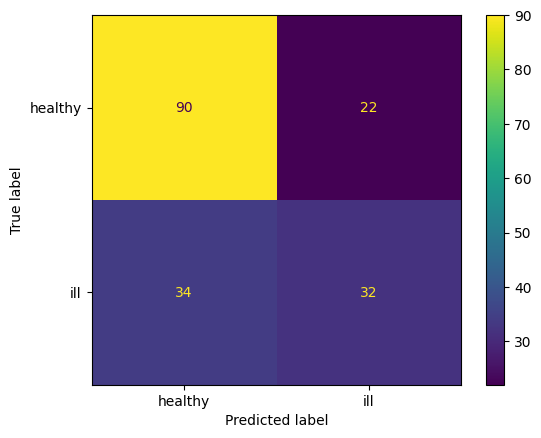

SVC -> {'cv': StratifiedKFold(n_splits=8, random_state=None, shuffle=False), 'error_score': nan, 'estimator__C': 1.0, 'estimator__break_ties': False, 'estimator__cache_size': 200, 'estimator__class_weight': None, 'estimator__coef0': 0.0, 'estimator__decision_function_shape': 'ovr', 'estimator__degree': 3, 'estimator__gamma': 'scale', 'estimator__kernel': 'rbf', 'estimator__max_iter': -1, 'estimator__probability': False, 'estimator__random_state': None, 'estimator__shrinking': True, 'estimator__tol': 0.001, 'estimator__verbose': False, 'estimator': SVC(), 'n_jobs': None, 'param_grid': {'C': [1, 10, 50, 70, 100]}, 'pre_dispatch': '2*n_jobs', 'refit': True, 'return_train_score': False, 'scoring': 'accuracy', 'verbose': 0}
Accuracy using cross-validation: SVC : 74.80237154150198 %
Variancy using cross-validation: SVC : 0.00349853145651393



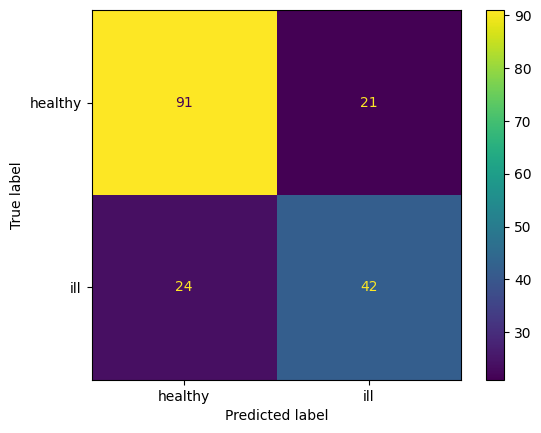

MultinomialNB -> {'cv': StratifiedKFold(n_splits=8, random_state=None, shuffle=False), 'error_score': nan, 'estimator__alpha': 1.0, 'estimator__class_prior': None, 'estimator__fit_prior': True, 'estimator__force_alpha': 'warn', 'estimator': MultinomialNB(), 'n_jobs': None, 'param_grid': {'alpha': [0.1, 0.5, 1.0]}, 'pre_dispatch': '2*n_jobs', 'refit': True, 'return_train_score': False, 'scoring': 'accuracy', 'verbose': 0}
Accuracy using cross-validation: MultinomialNB : 71.3191699604743 %
Variancy using cross-validation: MultinomialNB : 0.011931366585167719



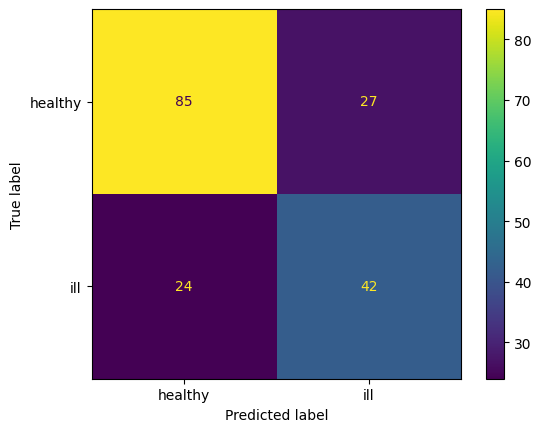

DecisionTreeClassifier -> {'cv': StratifiedKFold(n_splits=8, random_state=None, shuffle=False), 'error_score': nan, 'estimator__ccp_alpha': 0.0, 'estimator__class_weight': None, 'estimator__criterion': 'gini', 'estimator__max_depth': None, 'estimator__max_features': None, 'estimator__max_leaf_nodes': None, 'estimator__min_impurity_decrease': 0.0, 'estimator__min_samples_leaf': 1, 'estimator__min_samples_split': 2, 'estimator__min_weight_fraction_leaf': 0.0, 'estimator__random_state': None, 'estimator__splitter': 'best', 'estimator': DecisionTreeClassifier(), 'n_jobs': None, 'param_grid': {'max_depth': [None, 3, 5, 7, 10]}, 'pre_dispatch': '2*n_jobs', 'refit': True, 'return_train_score': False, 'scoring': 'accuracy', 'verbose': 0}
Accuracy using cross-validation: DecisionTreeClassifier : 60.69664031620554 %
Variancy using cross-validation: DecisionTreeClassifier : 0.005287769590995018



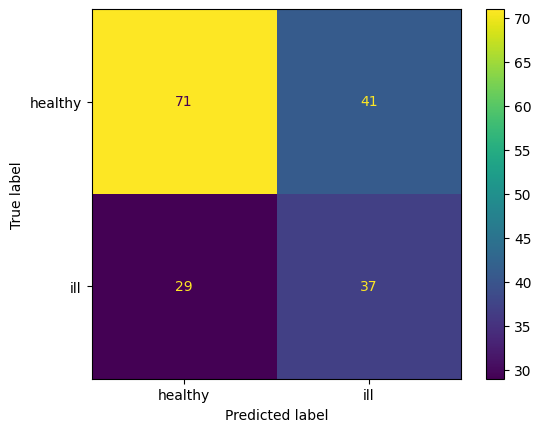

RandomForestClassifier -> {'cv': StratifiedKFold(n_splits=8, random_state=None, shuffle=False), 'error_score': nan, 'estimator__bootstrap': True, 'estimator__ccp_alpha': 0.0, 'estimator__class_weight': None, 'estimator__criterion': 'gini', 'estimator__max_depth': None, 'estimator__max_features': 'sqrt', 'estimator__max_leaf_nodes': None, 'estimator__max_samples': None, 'estimator__min_impurity_decrease': 0.0, 'estimator__min_samples_leaf': 1, 'estimator__min_samples_split': 2, 'estimator__min_weight_fraction_leaf': 0.0, 'estimator__n_estimators': 100, 'estimator__n_jobs': None, 'estimator__oob_score': False, 'estimator__random_state': None, 'estimator__verbose': 0, 'estimator__warm_start': False, 'estimator': RandomForestClassifier(), 'n_jobs': None, 'param_grid': {'n_estimators': [50, 100, 200, 300, 500]}, 'pre_dispatch': '2*n_jobs', 'refit': True, 'return_train_score': False, 'scoring': 'accuracy', 'verbose': 0}
Accuracy using cross-validation: RandomForestClassifier : 69.61462450592

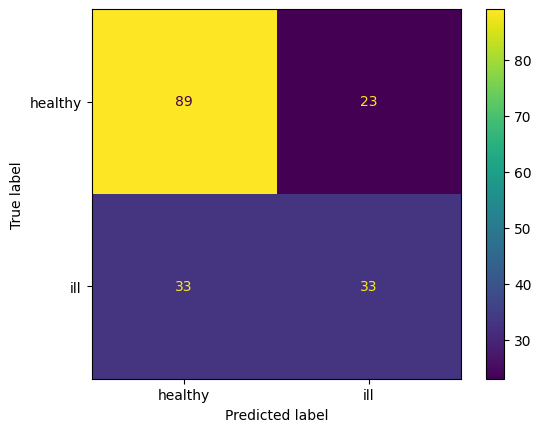

In [82]:
# @title PARAMETERS, ACCURACIES, VARAINCIES, CONFUSION MATRICES

for i in range(len(best_models)):

  model_name = classifiers_names[i]

  # Checking the params
  params = best_models[i].get_params()
  print(f'{model_name} -> {params}')

  # ACCURACY
  print(f'Accuracy using cross-validation: {acc_cross[i]}')

  # VARIANCY
  print(f'Variancy using cross-validation: {var_cross[i]}')
  print()

  # CONFUSION MATRICES
  #print(dataset_labels)
 # print(pred_cross[i])

  cm = confusion_matrix(dataset_labels, pred_cross[i])#, labels=[0,1])
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["healthy","ill"])
  disp.plot()
  plt.show()



In [83]:
# @title Results